In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

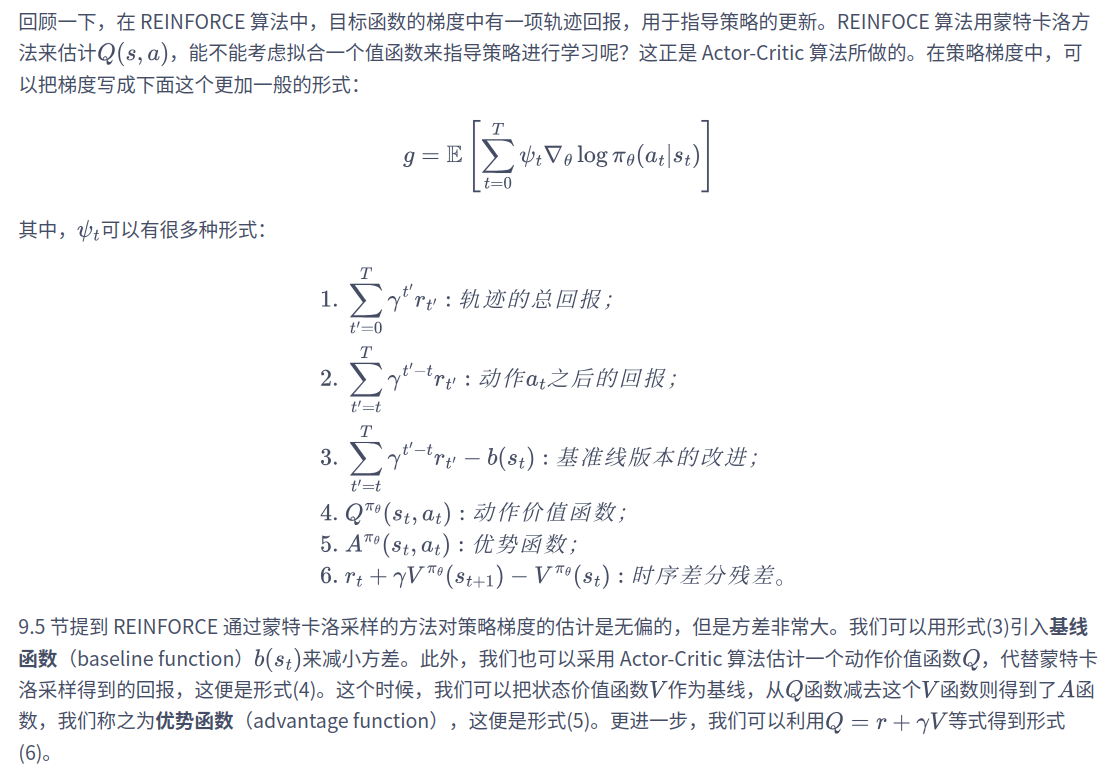

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)
        # 输出形状(batch_size,action_dim)

In [3]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
        # 输出形状(batch_size,1)
    

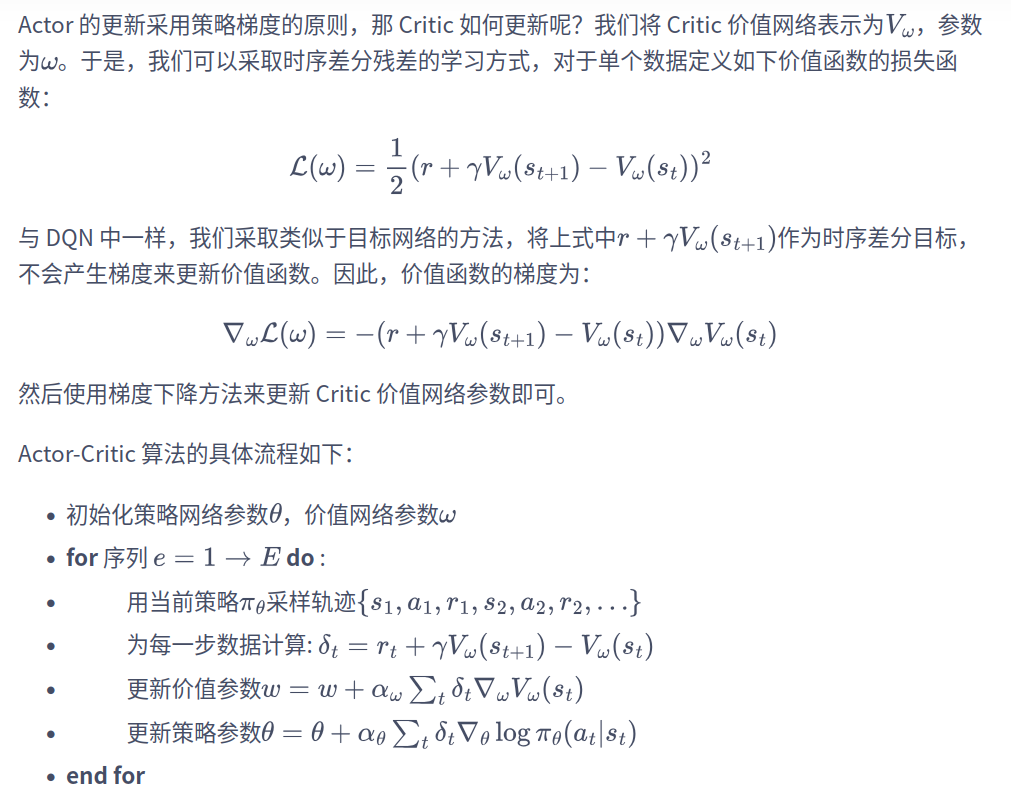

In [ ]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        # 如果state是元组，则提取第一个元素作为状态
        if isinstance(state, tuple):
            state = state[0]  # 假设状态在元组的第一个位置
        # state = torch.tensor([state], dtype=torch.float).to(self.device)
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):

        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)

        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_error = td_target - self.critic(states)  # 时序差分误差

        log_probs = torch.log(self.actor(states).gather(1, actions))
        # 策略网络loss
        actor_loss = torch.mean(-log_probs * td_error.detach())
        # td_error不要计算梯度
        # 均方误差(state_value网络)损失函数
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        # td_target固定不计算梯度
        
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

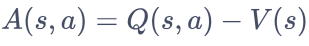  
$$TD\_target=r+\gamma V_w(s_{t+1})$$
Q(s,a)就是TD_target
$$TD\_error=TD\_target-V_w(s_t)$$
A(s,a)就是TD_error
$$actor\_loss=-\sum\limits^{T}_{t}TD\_error*log(\pi_{\theta}(a_t|s_t))$$
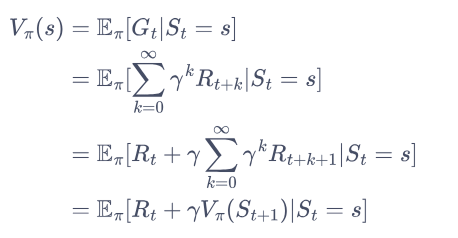  
$$critic\_loss=\frac{1}{2}(TD\_target-V_w(s_t))^2$$
两个loss里面的TD_target和TD_error都要进行固定作为常数,不对其计算梯度

In [5]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)


Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_139707/3985188633.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 100/100 [00:29<00:00,  3.40it/s, episode=1000, return=472.800]


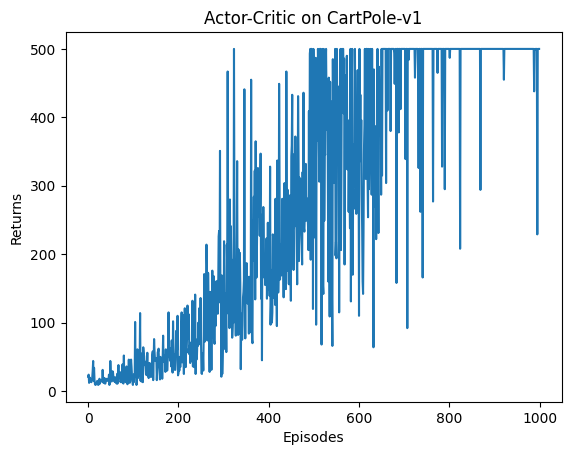

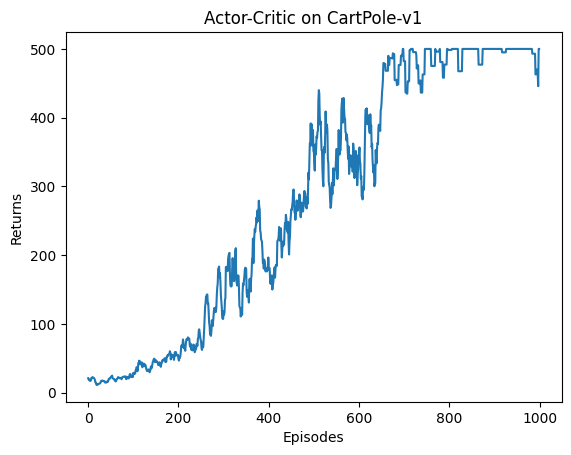

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()